# Imports, setting up device and seeds


In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [2]:
import os
import random

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

In [3]:
# torch.cuda.set_device(1)
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir("/content/drive/My Drive/SSNElab9")

# Constants

In [6]:
VALIDATION_PERCENTAGE = 0.10
batch_size = 8
TRAIN_PATH = 'train.pkl'
TEST_PATH = ""

# Reading training dataset

In [7]:
import pickle

with open(TRAIN_PATH, 'rb') as f:
    train = pickle.load(f)

In [8]:
train_lengths = [len(train_song[0]) for train_song in train]

In [9]:
type(train[0][0])

numpy.ndarray

# Histogram for training values

(array([152., 383., 229., 301., 297., 245., 212., 162., 103., 111.,  76.,
         67.,  87.,  49.,  42.,  37.,  23.,  27.,  22.,  25.,  17.,  16.,
         14.,  13.,  13.,  10.,  19.,  15.,  11.,  16.,   4.,   6.,   8.,
          8.,   2.,   5.,   3.,   5.,   5.,   5.,   6.,   4.,   4.,  11.,
          5.,   2.,   6.,   4.,   8.,   1.,   0.,   1.,   3.,   1.,   1.,
          2.,   1.,   2.,   0.,   2.,   1.,   2.,   3.,   0.,   0.,   0.,
          0.,   1.,   1.,   3.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.00000000e+00, 5.17575758e+01, 9.95151515e+01, 1.47272727e+02,
        1.95030303e+02, 2.42787879e+02

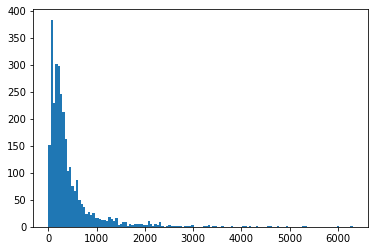

In [10]:
# histogram of lengths of training sequences
plt.hist(train_lengths, bins='auto')

In [11]:
min(train_lengths), max(train_lengths)

(4, 6308)

# Model

In [12]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size = out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        # x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        # all_outputs = torch.transpose(all_outputs, 0, 1)
        return all_outputs, hidden
    

In [13]:
    
model = LSTM_Seq_Regressor(1, 200, 1, 5).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 200, proj_size=5)
)

In [14]:
from torch.utils.data import Dataset

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

# Padding

In [15]:
from random import shuffle
from math import floor

# converting train to tensors
# train = [[torch.from_numpy(t[0].astype(int)).float(), torch.from_numpy(np.ndarray([int(t[1])]))] for t in train]
train_data = [[torch.from_numpy(t[0].astype(int)).float(), int(t[1])] for t in train]

dataset_length = len(train_data)
val_size = floor(dataset_length * VALIDATION_PERCENTAGE)
train_size = dataset_length - val_size

train_subset, val_subset = torch.utils.data.random_split(train_data, [train_size, val_size])

train_subset_data = [item[0] for item in train_subset]
train_subset_targets = [item[1] for item in train_subset]

val_subset_data = [item[0] for item in val_subset]
val_subset_targets = [item[1] for item in val_subset]

train_set = VariableLenDataset(train_subset_data, train_subset_targets)
val_set = VariableLenDataset(val_subset_data, val_subset_targets)

In [16]:
# len(train[0][0].astype(int))

In [17]:
# np.ndarray(train[0][0].astype(int))

In [18]:
# [[torch.from_numpy(t[0].astype(int)), int(t[1])] for t in train]

In [19]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)

    return xx_pad, yy

# def pad_collate(batch, pad_value=0):
#     xx, yy = zip(*batch)
#     x_lens = [len(x) for x in xx]
#     y_lens = [1 for y in yy]

#     xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
#     # yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

#     return xx_pad, yy, x_lens, y_lens

In [20]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

In [21]:
next(iter(train_loader))

(tensor([[ -1.,  -1.,  -1.,  ...,  12.,  -1.,  -1.],
         [ -1.,  -1.,  -1.,  ...,   0.,   0.,   0.],
         [  2.,  95.,  29.,  ...,   0.,   0.,   0.],
         ...,
         [132.,  92.,  28.,  ...,   0.,   0.,   0.],
         [  0.,  88., 159.,  ...,   0.,   0.,   0.],
         [ 32.,  79.,  79.,  ...,   0.,   0.,   0.]]),
 (1, 0, 3, 3, 0, 0, 0, 3))

In [22]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss_fun = nn.MSELoss()

# # Training loop
# for epoch in range(101):
#     for x, targets in train_loader:
#         x = x.to(device).unsqueeze(2)
#         # targets = targets.to(device)
#         hidden, state = model.init_hidden(x.size(0))
#         hidden, state = hidden.to(device), state.to(device) 

#         targets = torch.from_numpy(np.asarray(targets))
        
#         x = torch.transpose(x, 0, 1)
#         preds, _ = model(x, (hidden, state))
#         preds = torch.transpose(preds, 0, 1)

#         # print(x)
        
#         # x_lens = [len(xx) for xx in x]
#         # x_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
#         # print("XPACKED", x_packed.data)
#         # preds_packed, _ = model(x_packed, (hidden, state))
#         # preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
        
#         preds = preds.squeeze(2)
#         print(preds.shape)
#         print(targets)
#         optimizer.zero_grad()
#         mask = targets != pad
#         print("A", preds)
#         print("V", targets)
#         loss = loss_fun(preds[mask], targets[mask])
#         loss.backward()
#         optimizer.step()
#     if epoch % 10 == 0:
#         print(f"Epoch: {epoch}, loss: {loss.item():.3}")

In [23]:
%%time

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.CrossEntropyLoss()

epochs, losses, train_acc, val_acc = [], [], [], []

# Training loop
for epoch in range(200):
    epoch_loss = 0
    train_accuracy = 0
    val_accuracy = 0

    for x, targets in train_loader:
        model.train()
        # print("X", x.shape)
        targets = torch.from_numpy(np.asarray(targets))
        # print("TARGETS", targets.shape)
        x = x.to(device).unsqueeze(2)
#         x = x.unsqueeze(2)
        # print("X", x.shape)
        targets = targets.to(device)
        # print(x.size(0))
        hidden, state = model.init_hidden(x.size(1))
        hidden, state = hidden.to(device), state.to(device) 
        # print('X SHAPE', x.shape)
        # print('PREDS SHAPE', x.shape)
        # print("HIDDEN SHAPE", hidden.shape)
        preds, _ = model(x, (hidden,state))
        preds = preds.squeeze(2)
        optimizer.zero_grad()

        
        # print(preds.shape)
        # print(targets.shape)
        preds = preds[:,:, 4]
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()

        # save the current training information
        epoch_loss += float(loss)
        # train_accuracy += get_accuracy(model, train)
        # val_accuracy += get_accuracy(model, valid)

    losses.append(loss.item())
    epochs.append(epoch)
    # train_acc.append(train_accuracy/len(train_loader))
    # val_acc.append(val_accuracy/len(train_loader))
    # if epoch % 10 == 0:
    print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 7.05
Epoch: 1, loss: 3.03
Epoch: 2, loss: 3.36
Epoch: 3, loss: 5.2
Epoch: 4, loss: 6.27
Epoch: 5, loss: 5.21
Epoch: 6, loss: 5.17
Epoch: 7, loss: 4.08
Epoch: 8, loss: 4.51
Epoch: 9, loss: 3.37
Epoch: 10, loss: 2.6
Epoch: 11, loss: 3.2
Epoch: 12, loss: 2.1
Epoch: 13, loss: 2.38
Epoch: 14, loss: 1.41
Epoch: 15, loss: 2.59
Epoch: 16, loss: 1.81
Epoch: 17, loss: 6.97
Epoch: 18, loss: 1.43
Epoch: 19, loss: 2.14
Epoch: 20, loss: 5.33
Epoch: 21, loss: 7.45
Epoch: 22, loss: 4.36
Epoch: 23, loss: 1.54
Epoch: 24, loss: 7.71
Epoch: 25, loss: 6.04
Epoch: 26, loss: 1.11
Epoch: 27, loss: 2.5
Epoch: 28, loss: 4.78
Epoch: 29, loss: 1.6
Epoch: 30, loss: 3.98
Epoch: 31, loss: 5.48
Epoch: 32, loss: 2.06
Epoch: 33, loss: 3.14
Epoch: 34, loss: 5.24
Epoch: 35, loss: 4.59
Epoch: 36, loss: 2.15
Epoch: 37, loss: 1.21
Epoch: 38, loss: 2.31
Epoch: 39, loss: 5.43
Epoch: 40, loss: 2.14
Epoch: 41, loss: 6.76
Epoch: 42, loss: 3.15
Epoch: 43, loss: 1.44
Epoch: 44, loss: 5.2
Epoch: 45, loss: 5.9
Epoch:

In [24]:
def plot_results(epochs, losses):
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

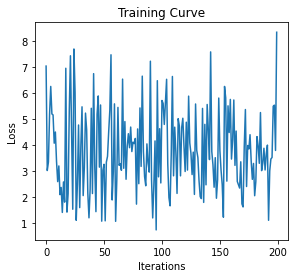

In [25]:
plot_results(epochs, losses)
